In [632]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [633]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.seg == 'segmented']
meta = meta[['mouse','date','area']]

In [634]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; nframe_trial = 223
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_ad = np.empty([0,1]); vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,1]); dfof_tg = np.empty([0,nori,nisi])
dfof_ad_std = np.empty([0,1]); dfof_tg_std = np.empty([0,nori,nisi])
trace = np.empty([0,nori,nisi,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property_loose' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['vis_cell_ad']), axis=0)
    vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
    well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
    ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
    fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nisi,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            for iisi in np.arange(nisi):
                trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, vis_tg.shape, well_fit.shape, ori_pref.shape, fit_param.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([97, 69, 53, 103, 39, 33, 93, 52],
 (539, 1),
 (539, 1),
 (539, 1),
 (539, 3),
 (539, 7, 3),
 (539, 1),
 (539, 8, 3),
 (539, 8, 3, 223))

In [635]:
meta['ncell'] = ncell
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
meta

,mouse,date,area,ncell
0,1322,200803,V1,97
1,1322,200804,LM,69
2,1322,200806,LI,53
3,1323,200720,V1,103
4,1323,200721,LM,39
5,1323,200723,LI,33
6,1324,200728,V1,93
7,1324,200729,LM,52


In [636]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell

,mouse,area
0,1322,V1
1,1322,V1
2,1322,V1
3,1322,V1
4,1322,V1
...,...,...
534,1324,LM
535,1324,LM
536,1324,LM
537,1324,LM


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [637]:
adp_mag = dfof_tg[:,0,[1,2]] / dfof_ad - 1

meta_cell_750 = meta_cell.copy(); meta_cell_750['isi'] = 750
meta_cell_250 = meta_cell.copy(); meta_cell_250['isi'] = 250
meta_cell_isi = pd.concat([meta_cell_750, meta_cell_250], ignore_index=True)

df_adp_mag = meta_cell_isi.copy()
df_adp_mag['adp_mag'] = adp_mag.flatten('F')
df_adp_mag['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_mag['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_mag = df_adp_mag[ df_adp_mag['vis_ad'] == 1 ]
df_adp_mag.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
963,1072,1324,LM,250,-0.815490,0.010215,1.0
964,1073,1324,LM,250,-0.744829,0.040586,1.0
965,1074,1324,LM,250,-0.274517,0.037092,1.0
966,1076,1324,LM,250,-1.451877,0.035262,1.0


In [638]:
df_adp_mag[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   267.0 -0.180326  0.665569 -2.163029 -0.469887 -0.221775  0.077338   
     250   267.0 -0.325477  0.616129 -3.004134 -0.654125 -0.378501 -0.058079   
LM   750   141.0 -0.051040  0.598336 -1.923241 -0.409122 -0.033545  0.211504   
     250   141.0 -0.648543  0.626268 -3.042202 -0.981837 -0.712494 -0.320640   
LI   750    76.0 -0.291396  0.618888 -2.013799 -0.698398 -0.270519  0.103593   
     250    76.0 -0.953516  0.612308 -2.862550 -1.238230 -0.989792 -0.658323   

                    
               max  
area isi            
V1   750  3.502958  
     250  3.622513  
LM   750  2.132582  
     250  1.490129  
LI   750  1.569319  
     250  0.894041

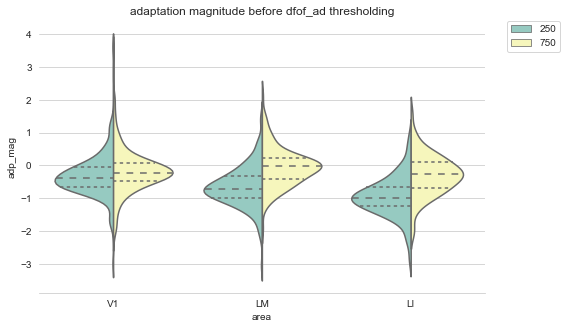

In [639]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_mag, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(title = 'adaptation magnitude before dfof_ad thresholding')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### add dfof_ad thresholding

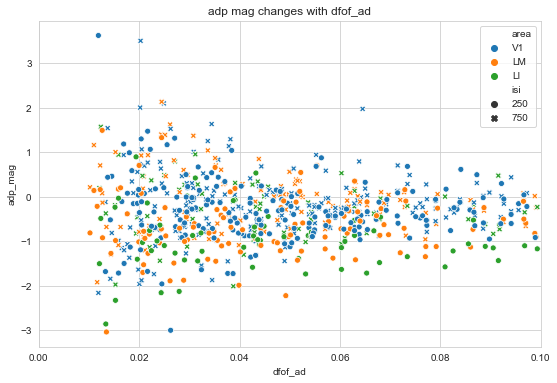

In [640]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df_adp_mag, x="dfof_ad", y="adp_mag", hue="area", style="isi")
# plt.xlim([0,0.8]);
plt.xlim([0,0.1]);
ax.set(title = 'adp mag changes with dfof_ad');

In [641]:
df = df_adp_mag.sort_values(by=['dfof_ad'])
df1 = df[df.isi == 750]
df2 = df[df.isi == 250]

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.title('adp mag rolling mean change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [642]:
def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.title('adp mag rolling std change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

cell selection: vis_ad only, with dfof_ad thresholding

In [643]:
dfof_threshold = 0.03
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= dfof_threshold]
df_adp_mag_thres.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
753,1067,1324,LM,250,-1.037747,0.047524,1.0
754,1073,1324,LM,250,-0.744829,0.040586,1.0
755,1074,1324,LM,250,-0.274517,0.037092,1.0
756,1076,1324,LM,250,-1.451877,0.035262,1.0


In [644]:
df_adp_mag_thres[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   215.0 -0.164490  0.492664 -1.875533 -0.395995 -0.188318  0.040594   
     250   215.0 -0.362663  0.443836 -1.729659 -0.648102 -0.399921 -0.124511   
LM   750   108.0 -0.100791  0.436052 -1.089206 -0.373513 -0.076079  0.111626   
     250   108.0 -0.635745  0.510077 -2.225924 -0.915844 -0.686542 -0.359696   
LI   750    56.0 -0.321286  0.502430 -2.013799 -0.632570 -0.270519 -0.025623   
     250    56.0 -0.922097  0.467841 -1.738642 -1.185452 -0.971112 -0.737692   

                    
               max  
area isi            
V1   750  1.972312  
     250  1.149798  
LM   750  1.369365  
     250  0.703521  
LI   750  0.951508  
     250  0.530749

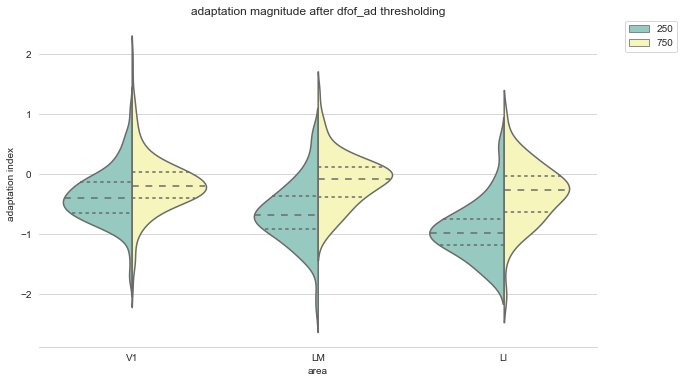

In [671]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.violinplot(data=df_adp_mag_thres, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'adaptation index', title = 'adaptation magnitude after dfof_ad thresholding');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [657]:
tt

,area,isi,adp_mag
0,1,750,-0.188318
1,2,750,-0.076079
2,3,750,-0.270519
3,1,250,-0.399921
4,2,250,-0.686542
5,3,250,-0.971112


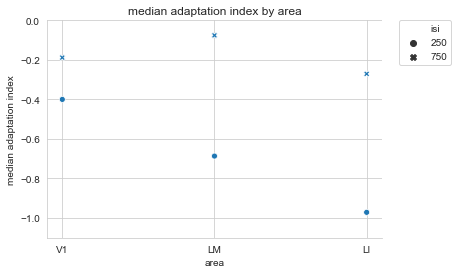

In [672]:
t = df_adp_mag_thres.copy()
tt = t[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).median().reset_index()

ax = sns.scatterplot(data=tt, x="area", y="adp_mag", style="isi"); sns.despine()
ax.set(ylabel = 'median adaptation index', title = 'median adaptation index by area')
plt.ylim([-1.1,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Adaptation tuning bias

In [646]:
tt = ori_pref.copy()
tt[tt > 90] = np.abs(tt[tt > 90] - 180)
tuning_bias = tt[:,[1,2]] - tt[:,[0]];

ori_pref_bin = tt[:,[0]];
ori_pref_bin[ori_pref_bin < 22.5] = 0; ori_pref_bin[ori_pref_bin > 67.5] = 90; 
ori_pref_bin[(ori_pref_bin >= 22.5) & (ori_pref_bin <= 67.5)] = 45; 

In [647]:
df_adp_tune = meta_cell_isi.copy()
df_adp_tune['tuning_bias'] = tuning_bias.flatten('F')
df_adp_tune['ori_pref_bin'] = np.concatenate((ori_pref_bin, ori_pref_bin), axis=0)

df_adp_tune['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_tune['well_fit'] = np.concatenate((well_fit, well_fit), axis=0)
df_adp_tune = df_adp_tune[ df_adp_tune['vis_ad'] == 1 ]
df_adp_tune = df_adp_tune[ df_adp_tune['well_fit'] == 1 ]

b, c = df_adp_tune.iloc[0].copy(), df_adp_tune.iloc[1].copy() 
df_adp_tune.iloc[0], df_adp_tune.iloc[1] = c, b # swap row 0 & 1 to sort df.gb properly
df_adp_tune.reset_index()

,index,mouse,area,isi,tuning_bias,ori_pref_bin,vis_ad,well_fit
0,0,1322,V1,750,12.444471,0.0,1.0,1.0
1,2,1322,V1,750,12.848284,45.0,1.0,1.0
2,3,1322,V1,750,3.611104,45.0,1.0,1.0
3,4,1322,V1,750,7.906208,45.0,1.0,1.0
4,5,1322,V1,750,-8.242688,90.0,1.0,1.0
...,...,...,...,...,...,...,...,...
275,1012,1324,V1,250,-46.021617,45.0,1.0,1.0
276,1019,1324,V1,250,0.665259,45.0,1.0,1.0
277,1020,1324,V1,250,-1.325048,45.0,1.0,1.0
278,1023,1324,V1,250,28.365979,45.0,1.0,1.0


In [648]:
df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).describe()

tuning_bias                                              \
                            count       mean        std        min        25%   
area isi ori_pref_bin                                                           
V1   750 0.0                 22.0   4.116519   8.092199 -10.872903  -2.054758   
         45.0                64.0   1.134649  13.155679 -31.564561  -5.027210   
         90.0                24.0  -4.299430   7.720660 -23.486719  -8.485737   
     250 0.0                 22.0   1.379351   8.638127 -15.476926  -2.222356   
         45.0                64.0  -0.030586  12.145115 -46.021617  -4.565760   
         90.0                24.0  -6.488708   9.135545 -26.746026  -9.838169   
LM   750 0.0                  4.0  -4.710133   1.795696  -6.284862  -6.254019   
         45.0                11.0  -2.753717  15.144688 -32.388121 -10.426646   
         90.0                 9.0  -8.864773  13.903293 -32.550006 -16.373484   
     250 0.0                  4.0  -1.892221  13.969391 -20.713656  -7.124616   
         45.0                11.0   7.148346   7.442578  -5.276405   3.974012   
         90.0                 9.0  -1.357321   7.696896 -17.315985  -5.717760   
LI   750 0.0                  1.0  -0.729991        NaN  -0.729991  -0.729991   
         45.0                 2.0   1.852169   0.004331   1.849106   1.850638   
         90.0                 3.0  -9.595521  10.711250 -21.629065 -13.841468   
     250 0.0                  1.0   5.396424        NaN   5.396424   5.396424   
         45.0                 2.0  -0.407821   1.915746  -1.762457  -1.085139   
         90.0                 3.0 -13.753773   6.980819 -19.041118 -17.710226   

                                                        
                             50%        75%        max  
area isi ori_pref_bin                                   
V1   750 0.0            4.206980   8.990739  22.372315  
         45.0           2.861452   8.686802  52.761022  
         90.0          -4.255796   1.357184   9.064453  
     250 0.0            0.985258   5.989740  17.297322  
         45.0           0.136459   4.372708  39.983653  
         90.0          -5.208103  -0.115983   8.991512  
LM   750 0.0           -4.736925  -3.193040  -3.081822  
         45.0           4.414960   6.587961  13.008474  
         90.0          -5.288462   1.840655   7.657974  
     250 0.0            0.398731   5.631126  12.347308  
         45.0           7.416267  10.176428  19.251685  
         90.0          -0.298521   3.388700   8.365668  
LI   750 0.0           -0.729991  -0.729991  -0.729991  
         45.0           1.852169   1.853701   1.855232  
         90.0          -6.053870  -3.578748  -1.103626  
     250 0.0            5.396424   5.396424   5.396424  
         45.0          -0.407821   0.269498   0.946816  
         90.0         -16.379333 -11.110101  -5.840868

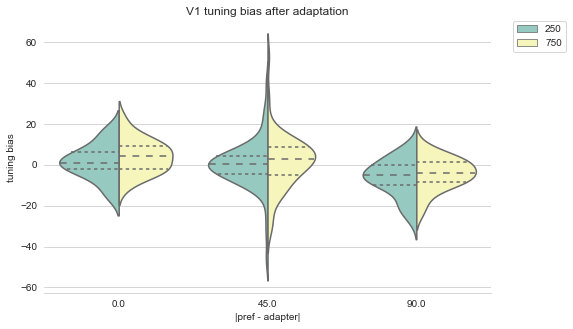

In [649]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_tune[df_adp_tune.area == 'V1'], 
                    x="ori_pref_bin", y="tuning_bias", hue="isi", 
                    split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'V1 tuning bias after adaptation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

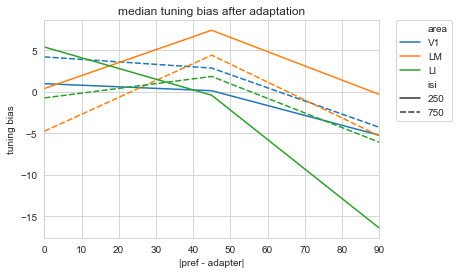

In [650]:
tt = df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).median().reset_index()

ax = sns.lineplot(data=tt, x="ori_pref_bin", y="tuning_bias", hue="area", style="isi");
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'median tuning bias after adaptation')
plt.xlim([0,90])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### Adaptation magnitude across |pref - ad|

In [ ]:
adp_mag = dfof_tg[:,0,[1,2]] / dfof_ad - 1
df_adp_mag['adp_mag'] = adp_mag.flatten('F')
df_adp_mag['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_mag['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_mag = df_adp_mag[ df_adp_mag['vis_ad'] == 1 ]
df_adp_mag.reset_index()


tt = ori_pref.copy()
tt[tt > 90] = np.abs(tt[tt > 90] - 180)
tuning_bias = tt[:,[1,2]] - tt[:,[0]];

ori_pref_bin = tt[:,[0]];
ori_pref_bin[ori_pref_bin < 22.5] = 0; ori_pref_bin[ori_pref_bin > 67.5] = 90; 
ori_pref_bin[(ori_pref_bin >= 22.5) & (ori_pref_bin <= 67.5)] = 45; 

df_adp_tune = meta_cell_isi.copy()
df_adp_tune['tuning_bias'] = tuning_bias.flatten('F')
df_adp_tune['ori_pref_bin'] = np.concatenate((ori_pref_bin, ori_pref_bin), axis=0)

df_adp_tune['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_tune['well_fit'] = np.concatenate((well_fit, well_fit), axis=0)
df_adp_tune = df_adp_tune[ df_adp_tune['vis_ad'] == 1 ]
df_adp_tune = df_adp_tune[ df_adp_tune['well_fit'] == 1 ]

b, c = df_adp_tune.iloc[0].copy(), df_adp_tune.iloc[1].copy() 
df_adp_tune.iloc[0], df_adp_tune.iloc[1] = c, b # swap row 0 & 1 to sort df.gb properly
df_adp_tune.reset_index()

dfof_threshold = 0.03
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= dfof_threshold]
df_adp_mag_thres.reset_index()

## Misc
### Adaptation increases variability (?)
for ori=0 target after adaptation, fano factor is higher than adapter  
cell selection: vis_ad only, with thresholding of dfof_ad & dfof_tg0

In [651]:
adp_fano_tg = dfof_tg_std[:,0,[1,2]] / dfof_tg[:,0,[1,2]]
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp
# adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_ad)

df_adp_fano = meta_cell_isi.copy()
df_adp_fano['adp_fano'] = adp_fano.flatten('F')
df_adp_fano['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)
df_adp_fano['dfof_tg'] = np.concatenate((dfof_tg[:,0,1], dfof_tg[:,0,2]), axis=0)

df_adp_fano['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_fano = df_adp_fano[ df_adp_fano['vis_ad'] == 1 ]

df_adp_fano = df_adp_fano[(df_adp_fano.dfof_ad >= dfof_threshold) & (df_adp_fano.dfof_tg >= dfof_threshold)]
df_adp_fano.reset_index()

,index,mouse,area,isi,adp_fano,dfof_ad,dfof_tg,vis_ad
0,0,1322,V1,750,0.198528,0.083296,0.063308,1.0
1,1,1322,V1,750,0.249547,0.079051,0.057910,1.0
2,2,1322,V1,750,0.224684,0.089755,0.098024,1.0
3,3,1322,V1,750,0.069735,0.149961,0.111251,1.0
4,4,1322,V1,750,0.079733,0.242218,0.230214,1.0
...,...,...,...,...,...,...,...,...
503,1040,1324,LM,250,0.136103,0.194892,0.174791,1.0
504,1045,1324,LM,250,0.091489,0.191068,0.180989,1.0
505,1053,1324,LM,250,0.329836,0.116363,0.086052,1.0
506,1061,1324,LM,250,-0.081032,0.052181,0.080558,1.0


In [652]:
df_adp_fano[['adp_fano','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_fano                                                              \
            count      mean       std       min       25%       50%       75%   
area isi                                                                        
V1   750    175.0  0.068245  0.149348 -0.318383 -0.037016  0.081278  0.167854   
     250    146.0  0.128114  0.173747 -0.346164  0.012119  0.120236  0.229368   
LM   750     92.0  0.030203  0.178669 -0.410187 -0.083335  0.036848  0.138752   
     250     44.0  0.153444  0.216884 -0.223757 -0.010786  0.147786  0.317559   
LI   750     40.0  0.006787  0.151909 -0.438364 -0.067491 -0.001452  0.103903   
     250     11.0  0.242941  0.224277 -0.173832  0.097539  0.259875  0.366242   

                    
               max  
area isi            
V1   750  0.397835  
     250  0.646350  
LM   750  0.478017  
     250  0.585548  
LI   750  0.361342  
     250  0.686797

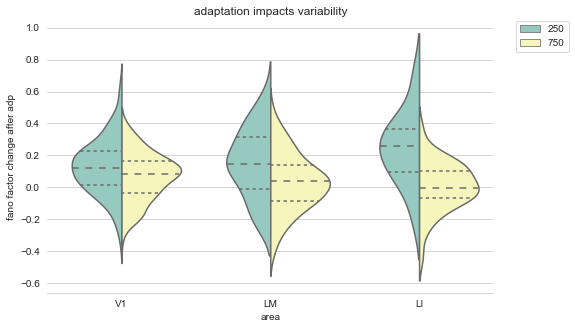

In [653]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_fano, x="area", y="adp_fano", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'fano factor change after adp', title = 'adaptation impacts variability')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);